# Assignment Three - CISC 351
## Mike Cruickshank (10130161)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import sys

# Suppress warnings about my bad code
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [4]:
# function to turn a date string into int value representing days since Jan 1 2000
def datestr_to_int(st):
    y = int(st[:4])
    m = int(st[5:7])
    d = int(st[8:10])
    return (365*(y-2000) + 30*m + d)
    

In [5]:
# function to turn a date int value representing days since Jan 1 2000 and return string
def dateint_to_str(int_in):
    y = int(int_in/365)+2000
    m = int((int_in % 365)/30 + 1)
    d = int((int_in % 365) % 30 + 1)
    return [str(y) + '-' + str(m) + '-' + str(d)]
    
    

Import Data:

In [6]:
# N = 2000
# events_info = pd.read_csv('events-info.csv', nrows = N)
# groups_info = pd.read_csv('groups-info.csv', nrows = 10000)
# members_info = pd.read_csv('members-info.csv', nrows = N)
# raw_relations = pd.read_csv('raw member-to-event attendance.csv', nrows = N)

In [7]:

events_info = pd.read_csv('events-info.csv') 
groups_info = pd.read_csv('groups-info.csv') 
members_info = pd.read_csv('members-info.csv') 
raw_relations = pd.read_csv('raw member-to-event attendance.csv')

In [8]:
raw_relations.head()


,Unnamed: 0,event_id,member_id,group_id
0,0,243930425,6770985,26140018
1,1,244208851,234724627,25604533
2,2,pxlktnywnbfb,199563568,25973656
3,3,pxlktnywnbfb,208888939,25973656
4,4,244444551,1720391,18571126


#### Split data into four sets based on event time

This was done in preparation for problem 3. 

In [9]:
n_events = len(events_info)
events_info['days_since_2000'] = np.zeros((n_events,1))
for i in range(n_events):
    if i % int((n_events/10)) == 0:
        print('%d%% Complete' % (100*i/n_events))
    events_info['days_since_2000'].iloc[i] = datestr_to_int(
        events_info['time'].iloc[i])
    

0% Complete
9% Complete
19% Complete
29% Complete
39% Complete
49% Complete
59% Complete
69% Complete
79% Complete
89% Complete
99% Complete


In [10]:
event_stats = events_info['days_since_2000'].describe()
print(event_stats)

count    19307.000000
mean      6254.746620
std        202.061322
min       5806.000000
25%       6100.000000
50%       6299.000000
75%       6430.000000
max       6535.000000
Name: days_since_2000, dtype: float64


In [11]:
print('First 25% of events happen between T0 and T1')
print('Second 25% of events happen between T1 and T2' )
print('Third 25% of events happen between T2 and T3')
print('Fourth 25% of events happen between T3 and T4')

print('T0 = ' + str(dateint_to_str(event_stats[3])))
print('T1 = ' + str(dateint_to_str(event_stats[4])))
print('T2 = ' + str(dateint_to_str(event_stats[5])))
print('T3 = ' + str(dateint_to_str(event_stats[6])))
print('T4 = ' + str(dateint_to_str(event_stats[7])))


First 25% of events happen between T0 and T1
Second 25% of events happen between T1 and T2
Third 25% of events happen between T2 and T3
Fourth 25% of events happen between T3 and T4
T0 = ['2015-12-2']
T1 = ['2016-9-21']
T2 = ['2017-4-5']
T3 = ['2017-8-16']
T4 = ['2017-12-1']


Data is split into four sets, based on date of event, for the purpose of link prediction in problem 3.

 * To train model, predict links made between T1 and T2 based on network at time T1
 * To test model, predict links made between T3 and T4 based on network at time T3
 * For problems 1 and 2, the complete network at time T4 will be used. However, networks will be created along the way for all four times to use in problem 3

In [12]:
events_first25p = events_info.loc[events_info['days_since_2000'] <= event_stats[4]]
events_first50p = events_info.loc[events_info['days_since_2000'] <= event_stats[5]]
events_first75p = events_info.loc[events_info['days_since_2000'] <= event_stats[6]]

raw_relations_25 = raw_relations[raw_relations['event_id'].isin(events_first25p['event_id'])]
raw_relations_50 = raw_relations[raw_relations['event_id'].isin(events_first50p['event_id'])]
raw_relations_75 = raw_relations[raw_relations['event_id'].isin(events_first75p['event_id'])]

# 
print(np.shape(raw_relations_25))
print(np.shape(raw_relations_50))
print(np.shape(raw_relations_75))
print(np.shape(raw_relations))


(35687, 4)
(66727, 4)
(98159, 4)
(126813, 4)


### Problem 1

#### Build weighted bipartite network representing member-to-group relationship (members and groups are nodes):

Determine number of rows that contain identical member and group numbers, and use this count as weight for network:

In [13]:
cols = ['member_id','group_id']
member_groups_25 = raw_relations_25[cols]
member_groups_25['Count'] = member_groups_25.groupby(['member_id'])['group_id'].transform('count')
member_groups_25 = member_groups_25.drop_duplicates()

member_groups_50 = raw_relations_50[cols]
member_groups_50['Count'] = member_groups_50.groupby(['member_id'])['group_id'].transform('count')
member_groups_50 = member_groups_50.drop_duplicates()

member_groups_75 = raw_relations_75[cols]
member_groups_75['Count'] = member_groups_75.groupby(['member_id'])['group_id'].transform('count')
member_groups_75 = member_groups_75.drop_duplicates()

member_groups = raw_relations[cols]
member_groups['Count'] = member_groups.groupby(['member_id'])['group_id'].transform('count')
member_groups = member_groups.drop_duplicates()

# member_groups_25.head(10)


Create bipartite network using networkx libary:

In [14]:
from networkx.algorithms import bipartite
import networkx as nx

In [15]:
G_small_for_vis = nx.from_pandas_edgelist(member_groups.iloc[0:10], 'member_id', 'group_id', 'Count') # small graph 
# for visualization purposes

G = nx.from_pandas_edgelist(member_groups, 'member_id', 'group_id', 'Count') 
G_25 = nx.from_pandas_edgelist(member_groups_25, 'member_id', 'group_id', 'Count') 
G_50 = nx.from_pandas_edgelist(member_groups_50, 'member_id', 'group_id', 'Count') 
G_75 = nx.from_pandas_edgelist(member_groups_75, 'member_id', 'group_id', 'Count') 

#nx.draw(G)
print(G_small_for_vis.number_of_nodes())
print(G.number_of_nodes())

16
25233


#### Describe Basic Network Statistics:

In [16]:

print(nx.info(G))
# M = bipartite.biadjacency_matrix(G, row_order = list(dict.fromkeys(member_groups['group_id'])),
#                                     column_order = list(dict.fromkeys(member_groups['member_id'])),
#                                     weight = 'Count')

#print(nx.info(G_25))
#print(nx.info(G_50))
#print(nx.info(G_75))


Name: 
Type: Graph
Number of nodes: 25233
Number of edges: 45583
Average degree:   3.6130


In [17]:
print('Number of Unique Members: %d' % len(np.unique(raw_relations['member_id'])))
print('Number of Unique Groups: %d' % len(np.unique(raw_relations['group_id'])))


Number of Unique Members: 24631
Number of Unique Groups: 602


Display a small part of the graph:

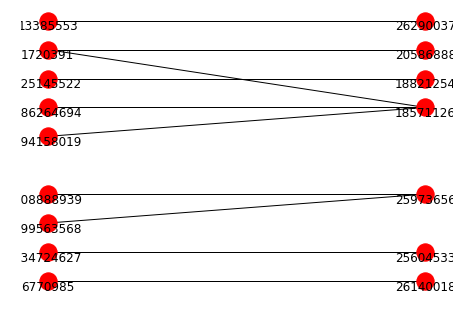

In [19]:
if (G.number_of_nodes() < 10):
    pos = {node:[0, i] for i,node in enumerate(member_groups_25['member_id'])}
    pos.update({node:[1, i] for i,node in enumerate(member_groups_25['group_id'])})
    lab = {node:[0, i] for i,node in enumerate(member_groups_25['Count'])}

    nx.draw(G, pos, with_labels=False)
    for p in pos:  # raise text positions
        pos[p][1] += -0.2
    nx.draw_networkx_labels(G, pos)
    plt.tight_layout()
    plt.show()
else:
    pos = {node:[0, i] for i,node in enumerate(member_groups['member_id'].iloc[0:10])}
    pos.update({node:[1, i] for i,node in enumerate(member_groups['group_id'].iloc[0:10])})

    nx.draw(G_small_for_vis, pos, with_labels=False)
    for p in pos:  # raise text positions
        pos[p][1] += -0.2
    nx.draw_networkx_labels(G_small_for_vis, pos)
    plt.tight_layout()
    plt.show()


In [20]:
number_of_groups = []
for i in member_groups['member_id']:
    number_of_groups.append(G.degree(i))

The following plot describes how many groups each member is part of:

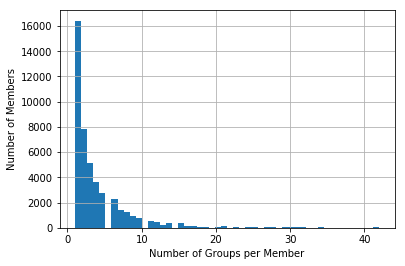

In [21]:
plt.hist(number_of_groups, bins = 50)
plt.ylabel('Number of Members')
plt.xlabel('Number of Groups per Member')
plt.grid()

In [22]:
number_of_members = []
for i in member_groups['group_id']:
    number_of_members.append(G.degree(i))

The following plot describes how many members each group has:

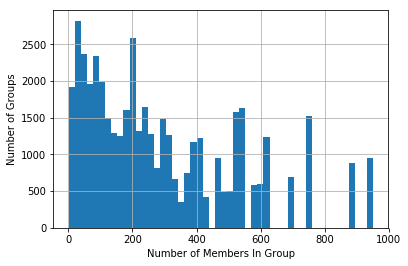

In [23]:
plt.hist(number_of_members, bins = 50)
plt.xlabel('Number of Members In Group')
plt.ylabel('Number of Groups')
plt.grid()

From these basic statistics and plots, we can conclude that there are many more members than groups. This is expected, as most groups will have many members. 

#### Build network representing member-to-member info (members are nodes):

In [24]:
raw_relations.head()

,Unnamed: 0,event_id,member_id,group_id
0,0,243930425,6770985,26140018
1,1,244208851,234724627,25604533
2,2,pxlktnywnbfb,199563568,25973656
3,3,pxlktnywnbfb,208888939,25973656
4,4,244444551,1720391,18571126


In [25]:
# creates table with two member columns, where a row represents two members in same group
def get_mem_to_mem(raw_relations,cols): 
    gm = raw_relations[cols]
    gm = gm.join(gm.set_index('group_id'), on='group_id', rsuffix='_other').reset_index(drop=True)
    gm = gm[gm['member_id'] != gm['member_id_other']]
    gm = gm.drop_duplicates()

    gm['Count'] = gm.groupby(['member_id', 'member_id_other'])['group_id'].transform('count')
    gm = gm.drop_duplicates()
    return gm


The following dataframes represent member connections. Each row contains two member ids and the group id that they both attended

In [26]:
gm = get_mem_to_mem(raw_relations,cols)
gm_25 = get_mem_to_mem(raw_relations_25,cols)
gm_50 = get_mem_to_mem(raw_relations_50,cols)
gm_75 = get_mem_to_mem(raw_relations_75,cols)

In [27]:
G2_small_for_vis = nx.from_pandas_edgelist(gm.iloc[0:10], 'member_id','member_id_other', 'Count')
G2 = nx.from_pandas_edgelist(gm, 'member_id','member_id_other', 'Count') # count values used as weights
G2_25 = nx.from_pandas_edgelist(gm_25, 'member_id','member_id_other', 'Count')
G2_50 = nx.from_pandas_edgelist(gm_50, 'member_id','member_id_other', 'Count')
G2_75 = nx.from_pandas_edgelist(gm_75, 'member_id','member_id_other', 'Count')



In [28]:
print(nx.info(G2))
# print(nx.info(G2_25))


Name: 
Type: Graph
Number of nodes: 24612
Number of edges: 6204861
Average degree: 504.2143


Display a graph of a small number of the connections (does not represent actual graph as many nodes missing, as some connections for visable nodes missing):

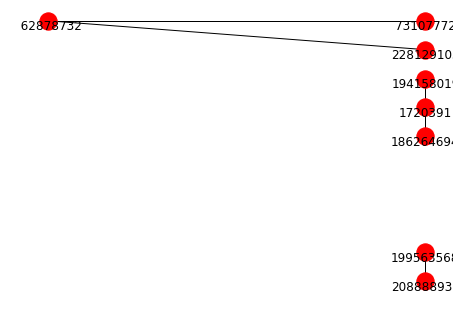

In [30]:
if (G2.number_of_nodes() < 10):
    pos = {node:[0, i] for i,node in enumerate(gm['member_id'])}

    nx.draw(G2, pos, with_labels=False)
    for p in pos:  # raise text positions
        pos[p][1] += -0.2
    nx.draw_networkx_labels(G2, pos)
    plt.tight_layout()
    plt.show()
else:
    pos = {node:[0, i] for i,node in enumerate(gm['member_id'].iloc[0:10])}
    pos.update({node:[1, i] for i,node in enumerate(gm['member_id_other'].iloc[0:10])})

    nx.draw(G2_small_for_vis, pos, with_labels=False)
    for p in pos:  # raise text positions
        pos[p][1] += -0.2
    nx.draw_networkx_labels(G2_small_for_vis, pos)
    plt.tight_layout()
    plt.show()


From this member-to-member network we can conclude that the average member is well connected to other members as the average degree is over 500. However, some members are much more connected than others.

#### Other potential networks:
Could do a weighted network with groups as nodes. Each weigh would be the number of mutual members. The motivation is to find groups that are similar to each other. From here, we could recommend new groups to members or be better able to predict when a member will join a group.

### Problem 2

#### Analysing the Group Member Network

#### Normalized degree centrality:

In [31]:
deg_cent = nx.degree_centrality(G2)
deg_cent_25 = nx.degree_centrality(G2_25)
deg_cent_50 = nx.degree_centrality(G2_50)
deg_cent_75 = nx.degree_centrality(G2_75)

The networkx centrality function returns values in odd (at least odd to me) format. So below is adding centrality and corresponding member number to array so that the top five can be displayed:

In [32]:
dc = []
dc_mem = []
count = 1
L = len(members_info['member_id'])
for i in members_info['member_id']:
    if (count+1 % 5000 == 0):
        print('%d of %d' % (count,L))
    count = count + 1
    if (len(gm.loc[gm['member_id'] == i]) > 0):
        dc_mem.append(i)
        dc.append(deg_cent[i])

In [33]:
sort_idx = np.argsort(dc)
dc_sorted = np.sort(dc)
dc_mem_arr = np.array(dc_mem)
dc_mem_sorted = dc_mem_arr[sort_idx]
norm_deg_centrality = pd.DataFrame()
norm_deg_centrality['member_id'] = dc_mem_sorted
norm_deg_centrality['normalized deg. centrality'] = dc_sorted


Top five members in graph ranked by degree centrality (bottom member has highest centrality):

In [34]:
norm_deg_centrality.tail(5)

,member_id,normalized deg. centrality
24567,175300482,0.247207
24568,3380276,0.260696
24569,46486792,0.278046
24570,221191725,0.295559
24571,8539046,0.344277


#### Katz Centrality:

In [107]:
katz_cent_25 = nx.katz_centrality(G2_25, alpha=0.001, beta=1.0, max_iter= 20, tol=1e-02, nstart=None, normalized=True, weight='Count')
katz_cent_75 = nx.katz_centrality(G2_75, alpha=0.001, beta=1.0, max_iter= 100, tol=5e-01, nstart=None, normalized=True, weight='Count')
katz_cent = nx.katz_centrality(G2, alpha=0.001, beta=1.00, max_iter= 100, tol=9e-1, nstart=None, normalized=True, weight='Count')

In [111]:
kc = []
kc_mem = []
count = 1
L = len(members_info['member_id'])
for i in members_info['member_id']:
    if count % int((L/25)) == 0:
        print('%d%% Complete' % (100*count/L))
    count = count + 1
    if (len(gm.loc[gm['member_id'] == i]) > 0):
        kc_mem.append(i)
        kc.append(katz_cent[i])

3% Complete
7% Complete
11% Complete
15% Complete
19% Complete
23% Complete
27% Complete
31% Complete
35% Complete
39% Complete
43% Complete
47% Complete
51% Complete
55% Complete
59% Complete
63% Complete
67% Complete
71% Complete
75% Complete
79% Complete
83% Complete
87% Complete
91% Complete
95% Complete
99% Complete


In [112]:
sort_idx = np.argsort(kc)
kc_sorted = np.sort(kc)
kc_mem_arr = np.array(kc_mem)
kc_mem_sorted = kc_mem_arr[sort_idx]
katz_centrality = pd.DataFrame()
katz_centrality['member_id'] = kc_mem_sorted
katz_centrality['katz centrality'] = kc_sorted


Top five members in graph ranked by katz centrality (bottom member has highest centrality):

In [113]:
katz_centrality.tail(5)

,member_id,katz centrality
24567,3380276,0.036866
24568,5900662,0.037687
24569,46486792,0.039703
24570,221191725,0.040112
24571,8539046,0.046603


#### Normalized Betweenness Centrality:

In [118]:
node_to_consider = 100  # node samples to estimate between, used to reduce computation time

betwn_cent = nx.betweenness_centrality(G2, endpoints = False,
                                        normalized = True,
                                        k = node_to_consider)  #approximation
betwn_cent_75 = nx.betweenness_centrality(G2_75, endpoints = False,
                                        normalized = True,
                                        k = node_to_consider)  #approximation
betwn_cent_25 = nx.betweenness_centrality(G2_25, endpoints = False,
                                        normalized = True,
                                        k = node_to_consider)  #approximation

In [119]:
bc = []
bc_mem = []
count = 1
L = len(members_info['member_id'])
for i in members_info['member_id']:
    if count % int((L/10)) == 0:
        print('%d%% Complete' % (100*count/L))
    count = count + 1
    if (len(gm.loc[gm['member_id'] == i]) > 0):
        bc_mem.append(i)
        bc.append(betwn_cent[i])

9% Complete
19% Complete
29% Complete
39% Complete
49% Complete
59% Complete
69% Complete
79% Complete
89% Complete
99% Complete


In [120]:
sort_idx = np.argsort(bc)
bc_sorted = np.sort(bc)
bc_mem_arr = np.array(bc_mem)
bc_mem_sorted = bc_mem_arr[sort_idx]
norm_betwn_centrality = pd.DataFrame()
norm_betwn_centrality['member_id'] = bc_mem_sorted
norm_betwn_centrality['normalized betweenness centrality'] = bc_sorted

Top five members in graph ranked by betweenness centrality:

In [121]:
norm_betwn_centrality.tail(5)

,member_id,normalized betweenness centrality
24567,14044231,0.010272
24568,221191725,0.011089
24569,175300482,0.011411
24570,144256692,0.012344
24571,8539046,0.031486


#### Eigenvector Centrality:

In [127]:
eigenval_cent = nx.eigenvector_centrality(G2, max_iter=10, tol=1e-04, nstart=None, weight='Count')
eigenval_cent_75 = nx.eigenvector_centrality(G2_75, max_iter=10, tol=1e-04, nstart=None, weight='Count')
eigenval_cent_25 = nx.eigenvector_centrality(G2_25, max_iter=10, tol=1e-04, nstart=None, weight='Count')

In [128]:
ec = []
ec_mem = []
count = 1
L = len(members_info['member_id'])
for i in members_info['member_id']:
    if count % int((L/10)) == 0:
        print('%d%% Complete' % (100*count/L))
    count = count + 1
    if (len(gm.loc[gm['member_id'] == i]) > 0):
        ec_mem.append(i)
        ec.append(eigenval_cent[i])

9% Complete
19% Complete
29% Complete
39% Complete
49% Complete
59% Complete
69% Complete
79% Complete
89% Complete
99% Complete


In [129]:
sort_idx = np.argsort(ec)
ec_sorted = np.sort(ec)
ec_mem_arr = np.array(ec_mem)
ec_mem_sorted = bc_mem_arr[sort_idx]
norm_eig_centrality = pd.DataFrame()
norm_eig_centrality['member_id'] = ec_mem_sorted
norm_eig_centrality['normalized eigenvector centrality'] = ec_sorted

Top five members in graph ranked by eigenvector centrality:

In [130]:
norm_eig_centrality.tail(5)

,member_id,normalized eigenvector centrality
24567,71851852,0.066570
24568,175300482,0.067629
24569,60195472,0.070314
24570,203244569,0.072224
24571,5900662,0.075165


In [288]:
print(G2.degree(8539046))
members_info.iloc[(np.where(members_info['member_id'] == 8539046)[0])]

8473


,member_id,name,hometown,city,state,lat,lon,key
1157,8539046,Shalini,NaN,Nashville,TN,36.13,-86.8,0


Based on the resulted for the four different centrality measurements presented above, we can conclude that the important nodes will depend on which centrality measurement we use. Therefore, all four are used as prediction attributes in problem three. 

Interestingly, member 8539046 (Shalini from Nashville, TN) is ranked as the most important member in 3 out of the 4 rankings. However, Shalini doesnt even rank in the top five for the eigenvector centrality ranking. Shalini's node in the member-to-member network has degree 8473.

### Problem 3

#### Performing Link Prediction on Member-to-Group Network

Create a dataframe with all possible group-to-member combinations:

In [131]:
N = 600   # only use first 600 memebers to reduce computation time
gm_all = groups_info
print(np.shape(gm_all))
print(np.shape(members_info.iloc[:N]))
groups_info['key'] = 0
members_info['key'] = 0

gm_all = groups_info.merge(members_info.iloc[:N], how='outer')

print(np.shape(gm_all))



(602, 8)
(600, 8)
(361200, 15)


Next, determine if each group-member combo actually exists at each point in time (super slow due to my insufficient python knowledge):

In [264]:
N_all = len(gm_all)
print(N_all)

gm_all['is_member_25'] = np.zeros((N_all,1))
gm_all['is_member_50'] = np.zeros((N_all,1))
gm_all['is_member_75'] = np.zeros((N_all,1))
gm_all['is_member_100'] = np.zeros((N_all,1))


for i in range(N_all):
    if i % (N_all/100) == 0:
        print('%.1f%% Complete' % (100*i/N_all))
    grp = gm_all['group_id'].iloc[i]
    memb = gm_all['member_id'].iloc[i]
    if G_25.has_edge(grp,memb):
        m_25 = 1
        m_50 = 1
        m_75 = 1
        m_100 = 1
    elif G_50.has_edge(grp,memb):
        m_25 = 0
        m_50 = 1
        m_75 = 1
        m_100 = 1
    elif G_75.has_edge(grp,memb):
        m_25 = 0
        m_50 = 0
        m_75 = 1
        m_100 = 1
    elif G.has_edge(grp,memb):
        m_25 = 0
        m_50 = 0
        m_75 = 0
        m_100 = 1
    else:
        m_25 = 0
        m_50 = 0
        m_75 = 0
        m_100 = 0

    cols_set = ['is_member_25','is_member_50','is_member_75','is_member_100']   
    vals_set = [m_25, m_50, m_75, m_100]
    gm_all.set_value(i, cols_set, vals_set)



361200
0.0% Complete
1.0% Complete
2.0% Complete
3.0% Complete
4.0% Complete
5.0% Complete
6.0% Complete
7.0% Complete
8.0% Complete
9.0% Complete
10.0% Complete
11.0% Complete
12.0% Complete
13.0% Complete
14.0% Complete
15.0% Complete
16.0% Complete
17.0% Complete
18.0% Complete
19.0% Complete
20.0% Complete
21.0% Complete
22.0% Complete
23.0% Complete
24.0% Complete
25.0% Complete
26.0% Complete
27.0% Complete
28.0% Complete
29.0% Complete
30.0% Complete
31.0% Complete
32.0% Complete
33.0% Complete
34.0% Complete
35.0% Complete
36.0% Complete
37.0% Complete
38.0% Complete
39.0% Complete
40.0% Complete
41.0% Complete
42.0% Complete
43.0% Complete
44.0% Complete
45.0% Complete
46.0% Complete
47.0% Complete
48.0% Complete
49.0% Complete
50.0% Complete
51.0% Complete
52.0% Complete
53.0% Complete
54.0% Complete
55.0% Complete
56.0% Complete
57.0% Complete
58.0% Complete
59.0% Complete
60.0% Complete
61.0% Complete
62.0% Complete
63.0% Complete
64.0% Complete
65.0% Complete
66.0% Complet

Below are function to compute the number of common neighbours and jaccards coefficient

 * Common neighbor is defined as neighbours two steps away from the member and one step away from the group, so you are comparing on same side of bipartite graph (based on paper by Chinta et al http://snap.stanford.edu/class/cs224w-2014/projects2014/cs224w-82-final.pdf)


In [266]:
def get_cn_and_jaccards(G, member, group):
    cn = -1
    j = -1
    if G.has_node(member) & G.has_node(group):
        member_neighbor = sorted(nx.neighbors(G,member))
        member_neighbor_2 = []
        for x in member_neighbor:
            temp = sorted(nx.neighbors(G,x))
            for y in temp:
                member_neighbor_2.append(y)
        group_neighbor = sorted(nx.neighbors(G,group))
        common_neighbors = [value for value in member_neighbor_2 if value in group_neighbor]
        
        for i in common_neighbors:
            if (i == member):
                cn  = (len(common_neighbors) - 1)
            else:
                cn = len(common_neighbors)

        denom = len(group_neighbor) + len(member_neighbor_2)
        if denom == 0:
            denom = 1
        for i in common_neighbors:
            if (i == member):
                if len(common_neighbors) == 1:
                    j = 0
                else:
                    j = ((len(common_neighbors) - 1)/(denom-2))
            else:
                j = (len(common_neighbors)/denom)
        return (cn,j)
    else: 
        return (-1,-1)

#### Train Model Using Common Neighbours and Jacccards Coefficient:

A big challenge for these models is the imbalance between number of links and non-links. To mitigate this, I will randomly remove most of the non-links from the dataframe so that there is a more equal balance.

 * In cell below, I find the indicies of the rows with group-member links at time T4 (the complete graph) then randomly select an a multiple number (2 x number of links) of other rows.

In [267]:
idx = np.where(gm_all['is_member_100'] == 1)[0]
N_ones = 1000
if len(idx > N_ones):
    rand_i = np.random.randint(len(idx), size=N_ones)
    idx = [idx[rand_i]][0]
N = int(2*len(idx))
print('Number of links at T4: %d, number of rows used for model:%d' % (len(idx),N+len(idx)))
idx_for_train = np.random.randint(len(gm_all), size=N)
for i in range(len(idx)):
    idx_for_train = np.append(idx_for_train,idx[i]) 


Number of links at T4: 1000, number of rows used for model:3000


In [268]:
gm_reduced = gm_all.iloc[idx_for_train] # reduce data set to only those rows corresponding to indicies found above
gm_reduced = gm_reduced.reset_index()
gm_reduced.head()

,index,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,key,member_id,name,hometown,city,state,lat,lon,is_member_25,is_member_50,is_member_75,is_member_100
0,230268,25140784,Couples Exploring Nashville,155,31,Socializing,9681725,Couples-Exploring-Nashville,0,4607639,Darcia,Hendersonville,Hendersonville,TN,36.32,-86.61,0.0,0.0,0.0,0.0
1,232345,18914937,Nashville SaltStack Meetup,26,34,Tech,96591722,Nashville-SaltStack-Users-Group,0,1921733,Sisco,NaN,Nashville,TN,36.11,-86.86,0.0,0.0,0.0,0.0
2,20004,20807142,Music City Young Professionals,1388,31,Socializing,7377000,MusicCityYP,0,2559067,Jane,Arrington,Arrington,TN,35.86,-86.66,0.0,0.0,0.0,0.0
3,281910,18286946,Dine and Unwind in East Nashville,2667,10,Food & Drink,173228792,Dine-and-Unwind-in-East-Nashville,0,4955979,Lea,"Valdosta, Georgia",Nashville,TN,36.08,-86.72,0.0,0.0,0.0,0.0
4,158289,11294262,Let's Talk Franklin Toastmasters Club,608,2,Career & Business,12742746,Lets-Talk-Franklin-Toastmasters-Club,0,4780315,catie,Nashville,Nashville,TN,36.08,-86.72,0.0,0.0,0.0,0.0


Below is the procedure to add the data from the member-to-member graph to enhance the predictions

 * If link doesnt exist at specified time, add -1 as the centrality measure
 * This is also a very slow operation, almost certain there is a better way to do this

In [271]:
import time
N_reduced = len(gm_reduced)
gm_reduced['common_neighbors_25'] = np.zeros((N_reduced,1))
gm_reduced['common_neighbors_75'] = np.zeros((N_reduced,1))
gm_reduced['jaccards_25'] = np.zeros((N_reduced,1))
gm_reduced['jaccards_75'] = np.zeros((N_reduced,1))
gm_reduced['degree_cent_25'] = np.zeros((N_reduced,1))
gm_reduced['degree_cent_75'] = np.zeros((N_reduced,1))
gm_reduced['betwn_cent_25'] = np.zeros((N_reduced,1))
gm_reduced['betwn_cent_75'] = np.zeros((N_reduced,1))
gm_reduced['katz_cent_25'] = np.zeros((N_reduced,1))
gm_reduced['katz_cent_75'] = np.zeros((N_reduced,1))
gm_reduced['eig_cent_25'] = np.zeros((N_reduced,1))
gm_reduced['eig_cent_75'] = np.zeros((N_reduced,1))

for i in range(N_reduced):
    if (i+1) % int((N_reduced/10)) == 0:
        print('%.1f%% Complete' % (100*i/N_reduced))
    
    t0 = time.clock()


    memb = gm_reduced['member_id'].iloc[i]
    grp = gm_reduced['group_id'].iloc[i]
    
    # add common neighbours and jaccards at time T1 and T3
    cn_25,j_25 = get_cn_and_jaccards(G_25, memb, grp)

    cn_75,j_75 =  get_cn_and_jaccards(G_75, memb, grp)

   

    # add centraliy measurements at time T1
    if G2_25.has_node(memb):        
        dc_25 = deg_cent_25[memb]
        bc_25 = betwn_cent_25[memb]
        ec_25 = eigenval_cent_25[memb]
        kc_25 = katz_cent_25[memb]

    else:
        dc_25 = -1
        bc_25 = -1
        ec_25 = -1
        kc_25 = -1

        
    # add centraliy measurements at time T3
    if G2_75.has_node(memb):       
        dc_75 = deg_cent_75[memb]
        bc_75 = betwn_cent_75[memb]
        ec_75 = eigenval_cent_75[memb]
        kc_75 = katz_cent_75[memb]

    else:
        dc_75 = -1
        bc_75 = -1
        ec_75 = -1
        kc_75 = -1
        
    cols_set = ['common_neighbors_25','jaccards_25','common_neighbors_75','jaccards_75','degree_cent_25','betwn_cent_25','eig_cent_25','katz_cent_25','degree_cent_75','betwn_cent_75','eig_cent_75','katz_cent_75']   
    vals_set = [cn_25,j_25,cn_75,j_75, dc_25, bc_25, ec_25, kc_25, dc_75, bc_75, ec_75, kc_75]
    gm_reduced.set_value(i, cols_set, vals_set)
   
    t1 = time.clock()
    #print("Time elapsed: ", t1 - t0) # CPU seconds elapsed (floating point)


gm_reduced.tail(5)

10.0% Complete
20.0% Complete
30.0% Complete
40.0% Complete
50.0% Complete
60.0% Complete
70.0% Complete
80.0% Complete
90.0% Complete
100.0% Complete


,index,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,key,member_id,...,jaccards_25,jaccards_75,degree_cent_25,degree_cent_75,betwn_cent_25,betwn_cent_75,katz_cent_25,katz_cent_75,eig_cent_25,eig_cent_75
2995,195179,2486942,Nashville Singularity Meetup,72,34,Tech,2256087,singularity-talk,0,2256087,...,-1.0,0.019608,0.001480,0.011900,0.000002,0.000110,0.006086,0.005677,6.184333e-05,1.629382e-03
2996,162072,20377949,Nashville Comedy Meetup,326,31,Socializing,212031851,Nashville-Comedy-Meetup,0,879954,...,-1.0,0.500000,-1.000000,0.001506,-1.000000,0.000000,-1.000000,0.004682,-1.000000e+00,3.078560e-05
2997,22718,19997487,Developer Launchpad Nashville,576,34,Tech,82204922,Developer-Launchpad-Nashville,0,5010820,...,-1.0,0.181668,-1.000000,0.064552,-1.000000,0.000024,-1.000000,0.011998,-1.000000e+00,2.801371e-02
2998,273568,1551589,Tarot Lights,177,22,New Age & Spirituality,5463788,TarotLights,0,5463788,...,0.5,0.500000,0.000296,0.000291,0.000000,0.000000,0.005968,0.004569,3.801438e-07,7.180999e-07
2999,54132,2556962,Middle Tennessee Motorcycle Riders,1055,3,Cars & Motorcycles,11578777,Middle-Tennessee-Motorcycle-Riders,0,1808238,...,0.5,0.275676,0.009179,0.019477,0.000000,0.000327,0.006607,0.006362,7.621432e-05,2.587464e-03



Find a subset to use for training that has:

 * No links after T1
 * Half of the members have links after T2

In [273]:
idx_0_25 = np.where(gm_reduced['is_member_25'] == 0)[0]
idx_1_50 = np.where(gm_reduced['is_member_50'] == 1)[0]

idx_train = np.union1d(np.intersect1d(idx_0_25,idx_1_50),np.setdiff1d(idx_0_25,idx_1_50)[:len(np.intersect1d(idx_0_25,idx_1_50))])



Find a subset to use for testing that has 

 * No links after T3, as we want to predict which possible group-member combos that arent currently linked will have a link at time T4


In [274]:
idx_0_75 = np.where(gm_reduced['is_member_75'] == 0)[0]
#idx_1_100 = np.where(gm_reduced['is_member_100'] == 1)[0]

#idx_test = np.union1d(np.intersect1d(idx_0_75,idx_1_100),np.setdiff1d(idx_0_75,idx_1_100)[:len(np.intersect1d(idx_0_75,idx_1_100))])
idx_test = idx_0_75


#### Link Prediction with Common Neighbours:

In [275]:
gm_reduced_train = gm_reduced.iloc[idx_train]


y = gm_reduced_train['is_member_50'].values

train_cols = ['num_members','common_neighbors_25','degree_cent_25','katz_cent_25','betwn_cent_25','eig_cent_25']
X = gm_reduced_train[train_cols]
X.head()


,num_members,common_neighbors_25,degree_cent_25,katz_cent_25,betwn_cent_25,eig_cent_25
0,155,-1.0,-1.000000,-1.000000,-1.0,-1.000000
1,26,-1.0,-1.000000,-1.000000,-1.0,-1.000000
2,1388,-1.0,0.006415,0.006386,0.0,0.000066
3,2667,-1.0,-1.000000,-1.000000,-1.0,-1.000000
4,608,-1.0,-1.000000,-1.000000,-1.0,-1.000000


In [276]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle = True)

ss = StandardScaler().fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


In [277]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


LR = LogisticRegression()
LR.fit(X_train, y_train)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
# print(LR.score(X_train, y_train))

# print(LR.predict(X_train))
# print(y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [279]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


gm_reduced_test = gm_reduced.iloc[idx_test]


y = gm_reduced_test['is_member_100'].values


test_cols = ['num_members','common_neighbors_75','degree_cent_75','katz_cent_75','betwn_cent_75','eig_cent_75']
X = gm_reduced_test[test_cols]
#X = pd.get_dummies(X, columns=['state'])
X_test, _, y_test, _ = train_test_split(X, y, test_size=0.0, random_state=42, shuffle = True)
X_test = ss.transform(X_test)
print('Linear Regression Accuracy: %0.2f' % LR.score(X_test,y_test))
print('Linear Regression f1 score: %0.2f' % f1_score(LR.predict(X_test),y_test))
print(classification_report(LR.predict(X_test),y_test))

print('Random Forest Accuracy: %0.2f' % RF.score(X_test,y_test))
print('Random Forest f1 score: %0.2f' % f1_score(RF.predict(X_test),y_test))
print(classification_report(RF.predict(X_test),y_test))



Linear Regression Accuracy: 0.80
Linear Regression f1 score: 0.30
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88      1681
         1.0       0.58      0.20      0.30       467

   micro avg       0.80      0.80      0.80      2148
   macro avg       0.70      0.58      0.59      2148
weighted avg       0.76      0.80      0.75      2148

Random Forest Accuracy: 0.71
Random Forest f1 score: 0.24
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      1487
         1.0       0.62      0.15      0.24       661

   micro avg       0.71      0.71      0.71      2148
   macro avg       0.67      0.55      0.53      2148
weighted avg       0.69      0.71      0.64      2148



#### Link Prediction with Jaccards Coefficient:

(same procedure as above except use Jaccards coefficient instead of common neighbours)

In [280]:
gm_reduced_train = gm_reduced.iloc[idx_train]


y = gm_reduced_train['is_member_50'].values

train_cols = ['num_members','jaccards_25','degree_cent_25','katz_cent_25','betwn_cent_25','eig_cent_25']
X = gm_reduced_train[train_cols]



In [281]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle = True)

ss = StandardScaler().fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


In [282]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifer


LR_j = LogisticRegression()
LR_j.fit(X_train, y_train)

RF_j = RandomForestClassifier()
RF_j.fit(X_train, y_train)
# print(LR.score(X_train, y_train))

# print(LR.predict(X_train))
# print(y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [283]:
gm_reduced_test = gm_reduced.iloc[idx_test]


y = gm_reduced_test['is_member_100'].values


test_cols = ['num_members','jaccards_75','degree_cent_75','katz_cent_75','betwn_cent_75','eig_cent_75']
X = gm_reduced_test[test_cols]
#X = pd.get_dummies(X, columns=['state'])
X_test, _, y_test, _ = train_test_split(X, y, test_size=0.0, random_state=42, shuffle = True)
X_test = ss.transform(X_test)
print('Linear Regression Accuracy: %0.2f' % LR_j.score(X_test,y_test))
print('Linear Regression f1 score: %0.2f' % f1_score(LR_j.predict(X_test),y_test))
print(classification_report(LR.predict(X_test),y_test))

print('Random Forest Accuracy: %0.2f' % RF_j.score(X_test,y_test))
print('Random Forest f1 score: %0.2f' % f1_score(RF_j.predict(X_test),y_test))
print(classification_report(RF.predict(X_test),y_test))



Linear Regression Accuracy: 0.71
Linear Regression f1 score: 0.26
              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81      1456
         1.0       0.65      0.15      0.24       692

   micro avg       0.70      0.70      0.70      2148
   macro avg       0.68      0.56      0.53      2148
weighted avg       0.69      0.70      0.63      2148

Random Forest Accuracy: 0.73
Random Forest f1 score: 0.24
              precision    recall  f1-score   support

         0.0       0.65      0.96      0.78      1352
         1.0       0.65      0.13      0.22       796

   micro avg       0.65      0.65      0.65      2148
   macro avg       0.65      0.54      0.50      2148
weighted avg       0.65      0.65      0.57      2148



The approaches presented above for predicting links created from time T3 to time T4 (one using number of common neighbors as link prediction from member-to-group graph, other uses jaccard coefficient) produce interesting results. Using common neighbours linear regression outperforms a random forest, whereas the opposite is true for Jaccards coefficient. 

The accurcy of the models is not surprising. Predicting links is challenging, and the poor recall values indicate a bias towards not predicting a new links when in fact there will be one. This is due to the imbalance between links and no links, even though I drastically reduced the number of non-links in the train and test set. 

To improve the above models, more of the metadata regarding the members and groups could have been used. For example, determine info about each group from its members (such as which state most of the members live in) and compare that to info about a new potential member-group link.